# Install & import libraries 📚

In [1]:
import sklearn
from tsai.basics import *
my_setup(sklearn)
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import mat73
import os
import subprocess
import sys
import tensorflow as tf
import numpy as np
from scipy.linalg import pinv
from scipy.linalg import logm
import pandas as pd

from tsai.optuna import *
import papermill as pm
from tsai.optuna import run_optuna_study
from fastcore.basics import *
from torch.cuda import amp

os              : Linux-5.10.221-llgrid-x86_64-with-glibc2.35
python          : 3.9.16
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
sklearn         : 1.2.2
torch           : 2.0.1+cu117
device          : 2 gpus (['Tesla V100-PCIE-32GB', 'Tesla V100-PCIE-32GB'])
cpu cores       : 40
threads per cpu : 2
RAM             : 377.57 GB
GPU memory      : [32.0, 32.0] GB


2024-09-03 13:33:22.017462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 13:33:23.159182: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 13:33:27.612760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-03 13:33:27.612891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# Check for GPUs
# Change the CUDA_VISIBLE_DEVICES values to numbers
# See (https://forums.fast.ai/t/exception-occured-in-lrfinder-when-calling-event-after-fit/104389/8)
if torch.cuda.is_available():
    result = subprocess.check_output("nvidia-smi -L | grep -oE '[0-9]+:' | tr -d ':'", shell=True).decode("utf-8").strip()
    os.environ['CUDA_VISIBLE_DEVICES'] = result

    print(os.environ['CUDA_VISIBLE_DEVICES'])

0
1


In [3]:
torch.cuda.is_available()

True

# Model and Data Selection

In [4]:
# Define the available options
data_options = ["NRLMSISE", "TIEGCM"]

# Ask the user to select a data set
print("Please select a data set:")
for i, option in enumerate(data_options, 1):
    print(f"{i}. {option}")
data_choice = int(input("Enter the number of your choice: "))
data_name = data_options[data_choice - 1]

# Use the data_name in your naming path
path = f"data/{data_name}"

Please select a data set:
1. NRLMSISE
2. TIEGCM


Enter the number of your choice:  1


## Data preparation

### Prepare dataframe

In [5]:
from datetime import datetime, timedelta

# Conver UTC year to Datetime helper function
def day_ut_year_to_datetime(day_of_year, ut_hours, year):
    date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
    time = timedelta(hours=ut_hours)
    return date + time

#### Choose Training, Validation, and Test Density Data Model

In [6]:
# NRLMSISE
if data_name == 'NRLMSISE':
    df_raw = loadmat('data/Atmospheric Density ROMs/NRLMSISE_1997_2008_ROM_r100.mat')

# TIEGCM
if data_name == 'TIEGCM':
    df_raw = scipy.io.loadmat('data/Atmospheric Density ROMs/TIEGCM_1997_2008_ROM_r100.mat')

#### Reduced-Order Modeling (ROM) Method: Proper Orthogonal Decomposition (POD)

In [7]:
# POD Dimension

# Reduced-order dimension
r=10
    
# Load first 10 modes of normalized data
X = df_raw["densityDataLogVarROM100"][:r,:-1];
 
if data_name == 'TIEGCM':
        
    ## Space weather inputs: [doy; UThrs; F10; F10a; Kp]
    U1 = np.zeros((11, df_raw["SWdataFull"].shape[0]-1))
    U1[:5,:] = df_raw["SWdataFull"][:-1,:].T 
    # Add future values
    U1[5,:] = df_raw["SWdataFull"][1:,2].T # DSTDTC
    U1[6,:] = df_raw["SWdataFull"][1:,4].T # F10
    # Add quadratic DSTDTC
    U1[7,:] = (df_raw["SWdataFull"][:-1,4]**2).T # DSTDTC^2
    U1[8,:] = (df_raw["SWdataFull"][1:,4]**2).T # DSTDTC^2
    # Add mixed terms
    U1[9,:] = (df_raw["SWdataFull"][:-1,4]*df_raw["SWdataFull"][:-1,2]).T
    U1[10,:] = (df_raw["SWdataFull"][1:,4]*df_raw["SWdataFull"][1:,2]).T

    # Concatenate Reduced-Order Density Data and SW Inputs
    X_U = np.concatenate((X.T, U1.T), axis=1)

    df = pd.DataFrame.from_dict(X_U)

    # Column labels
    df.columns = ['x_1','x_2','x_3','x_4','x_5','x_6','x_7','x_8','x_9','x_10','doy','UThrs','F10','F10a','Kp','DSTDTC','S10','DSTDTC^2','DSTDTC^2_future','Mixed','Mixed_future']
    df['index_column'] = df.index

    # Start year of data
    year = 1997
        
elif data_name == 'NRLMSISE':
        
    # Space weather inputs: [doy; UThrs; F10a; F10; ap; ap; ap; ap; ap; ap; ap; ap]
    U1 = np.zeros((40, df_raw["SWdataFull"].shape[0] - 1))
    U1[:11, :] = df_raw["SWdataFull"][:-1, :].T  

    # Add future values
    U1[11:20, :] = df_raw["SWdataFull"][1:, 2:11].T  

    # Add quadratic DSTDTC
    U1[20:29, :] = (df_raw["SWdataFull"][:-1, 2:11] ** 2).T
    U1[29:38, :] = (df_raw["SWdataFull"][1:, 2:11] ** 2).T

    # Add mixed terms
    U1[38, :] = df_raw["SWdataFull"][:-1, 3] * df_raw["SWdataFull"][:-1, 5]
    U1[39, :] = df_raw["SWdataFull"][1:, 3] * df_raw["SWdataFull"][1:, 5]

    # Concatenate Reduced-Order Density Data and SW Inputs
    X_U = np.concatenate((X.T, U1.T), axis=1)

    df = pd.DataFrame.from_dict(X_U)

    # Column labels
    df.columns = ['x_1','x_2','x_3','x_4','x_5','x_6','x_7','x_8','x_9','x_10','doy','UThrs','F10a','F10','ap1','ap2','ap3','ap4','ap5','ap6','ap7','F10a_future','F10_future','ap1_future','ap2_future','ap3_future','ap4_future','ap5_future','ap6_future','ap7_future','F10a^2','F10^2','ap1^2','ap2^2','ap3^2','ap4^2','ap5^2','ap6^2','ap7^2','F10a_future^2','F10_Future^2','ap1_future^2','ap2_future^2','ap3_future^2','ap4_future^2','ap5_future^2','ap6_future^2','ap7_future^2','Mixed','Mixed_future']
    df['index_column'] = df.index
        
    year = 1997

In [8]:
# Add in datetimes
doy = df['doy']
UThrs = df['UThrs']
date = []

for i in range(len(df['doy'])-1):
    date.append(day_ut_year_to_datetime(doy[i], UThrs[i], year))
    if i+1 < len(df['doy']) and doy[i+1] < doy[i]:
        year = year + 1

# Handle the last entry separately
date.append(day_ut_year_to_datetime(doy.iloc[-1], UThrs.iloc[-1], year))

df['date'] = pd.DatetimeIndex(date)
df['date'] = date
df_raw = df

low solar activity
              x_1        x_2       x_3       x_4       x_5       x_6   
0       80.248349  15.087977 -2.017683 -2.114424  1.530051  0.357361  \
1       79.837508  15.020188 -2.620749 -2.203850  1.990848  0.483833   
2       79.378006  14.920938 -3.258571 -2.298007  2.542756  0.654517   
3       78.944641  14.803476 -3.884907 -2.404868  3.129909  0.849967   
4       78.566057  14.675706 -4.456213 -2.516382  3.712642  1.055074   
...           ...        ...       ...       ...       ...       ...   
105186  84.526434  14.431957  0.191117 -1.915152  3.401182  2.386590   
105187  84.690273  14.581023  0.721789 -1.825364  2.915399  2.235120   
105188  85.015327  14.796722  1.045624 -1.842048  2.504388  2.093377   
105189  85.309502  15.010482  1.124382 -1.922479  2.235399  1.983040   
105190  85.584703  15.215417  0.946682 -2.072997  2.122599  1.910359   

             x_7       x_8       x_9      x_10  ...  ap3_future^2   
0       2.625152  0.163665  3.064600 -1.008469 

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,date
0,80.248349,15.087977,-2.017683,-2.114424,1.530051,0.357361,2.625152,0.163665,3.064600,-1.008469,...,16.0,49.000000,36.000000,49.000000,16.000000,30.250000,102.515625,488.600000,488.600000,1997-01-01 00:00:00
1,79.837508,15.020188,-2.620749,-2.203850,1.990848,0.483833,1.795672,0.518389,3.496913,-0.794192,...,16.0,44.444444,40.111111,44.444444,25.000000,29.340278,105.062500,488.600000,465.333333,1997-01-01 01:00:00
2,79.378006,14.920938,-3.258571,-2.298007,2.542756,0.654517,0.892025,0.734218,3.795352,-0.537918,...,16.0,40.111111,44.444444,40.111111,36.000000,28.444444,107.640625,465.333333,442.066667,1997-01-01 02:00:00
3,78.944641,14.803476,-3.884907,-2.404868,3.129909,0.849967,-0.021079,0.794369,3.942913,-0.261695,...,16.0,36.000000,49.000000,36.000000,49.000000,27.562500,110.250000,442.066667,418.800000,1997-01-01 03:00:00
4,78.566057,14.675706,-4.456213,-2.516382,3.712642,1.055074,-0.881215,0.697631,3.933943,0.014764,...,16.0,25.000000,44.444444,40.111111,44.444444,29.340278,108.506944,418.800000,349.000000,1997-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105186,84.526434,14.431957,0.191117,-1.915152,3.401182,2.386590,3.696237,-2.584486,-1.334667,-0.860033,...,169.0,144.000000,81.000000,81.000000,324.000000,45.562500,0.562500,729.300000,795.600000,2008-12-31 18:00:00
105187,84.690273,14.581023,0.721789,-1.825364,2.915399,2.235120,4.403301,-2.105432,-0.948203,-1.042399,...,169.0,121.000000,100.000000,81.000000,225.000000,56.250000,0.444444,795.600000,729.300000,2008-12-31 19:00:00
105188,85.015327,14.796722,1.045624,-1.842048,2.504388,2.093377,4.825018,-1.532386,-0.359749,-1.190717,...,169.0,100.000000,121.000000,81.000000,144.000000,68.062500,0.340278,729.300000,663.000000,2008-12-31 20:00:00
105189,85.309502,15.010482,1.124382,-1.922479,2.235399,1.983040,4.934075,-0.899027,0.349634,-1.282031,...,169.0,81.000000,144.000000,81.000000,81.000000,81.000000,0.250000,663.000000,596.700000,2008-12-31 21:00:00


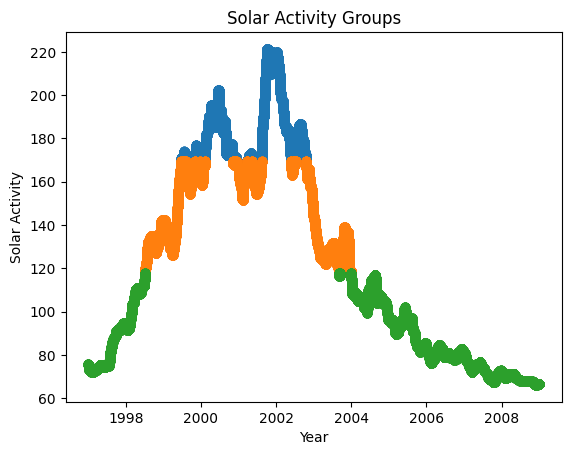

In [9]:
# Divide Dataset with respect to level of solar activity

df['F10a_group'] = pd.cut(df['F10a'], 3)

solar_grouped = df.groupby(pd.cut(df['F10a'], 3,labels=['low solar activity','medium solar activity','high solar activity']))
for key, item in solar_grouped:
    print(key)
    print(solar_grouped.get_group(key), "\n\n")    
        
# Plot Divided Dataset
plt.scatter(solar_grouped.get_group('high solar activity')['date'],solar_grouped.get_group('high solar activity')['F10a'],label='High Solar Activity')
plt.scatter(solar_grouped.get_group('medium solar activity')['date'],solar_grouped.get_group('medium solar activity')['F10a'],label='Medium Solar Activity')
plt.scatter(solar_grouped.get_group('low solar activity')['date'],solar_grouped.get_group('low solar activity')['F10a'],label='Low Solar Activity')
plt.title('Solar Activity Groups')
plt.ylabel('Solar Activity')
plt.xlabel('Year')
    
# Create dataframe splits
low_df = solar_grouped.get_group('low solar activity').drop(columns=['index_column','F10a_group'])
medium_df = solar_grouped.get_group('medium solar activity').drop(columns=['index_column','F10a_group'])
high_df = solar_grouped.get_group('high solar activity').drop(columns=['index_column','F10a_group'])
df.drop(columns=['index_column','F10a_group'])

### Proprocess dataframe

`tsai` provides some sklearn-style transforms that can be used to build a preprocessing pipeline. In this case we'll use the following transforms: 

* TSShrinkDataFrame: to save some memory and set the right dtypes.
* TSDropDuplicates: to ensure there are no duplicate timestamps.
* TSAddMissingTimestamps: to fill any missing timestamps. 
* TSFillMissing: to fill any missing data (forward fill, then 0).

All these transforms can be applied to the entire dataset. In other words, they are not dependent on the training set. Other transforms will be applied later, when the training split is available.

You can read about all available transforms in the [docs](https://timeseriesai.github.io/tsai/data.preprocessing.html#sklearn-api-transforms).

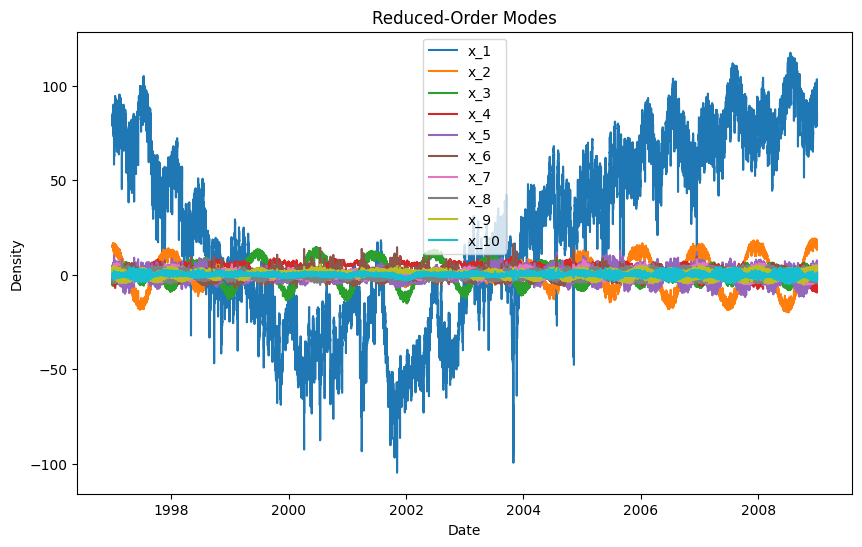

In [10]:
plt.figure(figsize=(10,6))  # Plot density data reduced order modes
plt.plot(df_raw["date"],df_raw["x_1"], label='x_1')
plt.plot(df_raw["date"],df_raw["x_2"], label='x_2')
plt.plot(df_raw["date"],df_raw["x_3"], label='x_3')
plt.plot(df_raw["date"],df_raw["x_4"], label='x_4')
plt.plot(df_raw["date"],df_raw["x_5"], label='x_5')
plt.plot(df_raw["date"],df_raw["x_6"], label='x_6')
plt.plot(df_raw["date"],df_raw["x_7"], label='x_7')
plt.plot(df_raw["date"],df_raw["x_8"], label='x_8')
plt.plot(df_raw["date"],df_raw["x_9"], label='x_9')
plt.plot(df_raw["date"],df_raw["x_10"], label='x_10')
plt.title("Reduced-Order Modes")
plt.ylabel("Density")
plt.xlabel("Date")
plt.legend()
plt.show()


#### Create new preprocessing

In [11]:
low_df.reset_index(drop=True, inplace=True)
medium_df.reset_index(drop=True, inplace=True)
high_df.reset_index(drop=True, inplace=True)

In [12]:
df_raw.drop(columns=['index_column','F10a_group'])

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,date
0,80.248349,15.087977,-2.017683,-2.114424,1.530051,0.357361,2.625152,0.163665,3.064600,-1.008469,...,16.0,49.000000,36.000000,49.000000,16.000000,30.250000,102.515625,488.600000,488.600000,1997-01-01 00:00:00
1,79.837508,15.020188,-2.620749,-2.203850,1.990848,0.483833,1.795672,0.518389,3.496913,-0.794192,...,16.0,44.444444,40.111111,44.444444,25.000000,29.340278,105.062500,488.600000,465.333333,1997-01-01 01:00:00
2,79.378006,14.920938,-3.258571,-2.298007,2.542756,0.654517,0.892025,0.734218,3.795352,-0.537918,...,16.0,40.111111,44.444444,40.111111,36.000000,28.444444,107.640625,465.333333,442.066667,1997-01-01 02:00:00
3,78.944641,14.803476,-3.884907,-2.404868,3.129909,0.849967,-0.021079,0.794369,3.942913,-0.261695,...,16.0,36.000000,49.000000,36.000000,49.000000,27.562500,110.250000,442.066667,418.800000,1997-01-01 03:00:00
4,78.566057,14.675706,-4.456213,-2.516382,3.712642,1.055074,-0.881215,0.697631,3.933943,0.014764,...,16.0,25.000000,44.444444,40.111111,44.444444,29.340278,108.506944,418.800000,349.000000,1997-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105186,84.526434,14.431957,0.191117,-1.915152,3.401182,2.386590,3.696237,-2.584486,-1.334667,-0.860033,...,169.0,144.000000,81.000000,81.000000,324.000000,45.562500,0.562500,729.300000,795.600000,2008-12-31 18:00:00
105187,84.690273,14.581023,0.721789,-1.825364,2.915399,2.235120,4.403301,-2.105432,-0.948203,-1.042399,...,169.0,121.000000,100.000000,81.000000,225.000000,56.250000,0.444444,795.600000,729.300000,2008-12-31 19:00:00
105188,85.015327,14.796722,1.045624,-1.842048,2.504388,2.093377,4.825018,-1.532386,-0.359749,-1.190717,...,169.0,100.000000,121.000000,81.000000,144.000000,68.062500,0.340278,729.300000,663.000000,2008-12-31 20:00:00
105189,85.309502,15.010482,1.124382,-1.922479,2.235399,1.983040,4.934075,-0.899027,0.349634,-1.282031,...,169.0,81.000000,144.000000,81.000000,81.000000,81.000000,0.250000,663.000000,596.700000,2008-12-31 21:00:00


In [13]:
# save raw dataframes
mkdir('training/dataframes/', exist_ok=True, parents=True)

save_object(low_df, 'training/dataframes/low_df_raw_'+path+'.pkl')
save_object(medium_df, 'training/dataframes/medium_df_raw_'+path+'.pkl')
save_object(high_df, 'training/dataframes/high_df_raw_'+path+'.pkl')

training/dataframes/low_df_raw_data directory created.
DataFrame saved as training/dataframes/low_df_raw_data/NRLMSISE.pkl
training/dataframes/medium_df_raw_data directory created.
DataFrame saved as training/dataframes/medium_df_raw_data/NRLMSISE.pkl
training/dataframes/high_df_raw_data directory created.
DataFrame saved as training/dataframes/high_df_raw_data/NRLMSISE.pkl


In [14]:
datetime_col = "date"
freq = '1H'
columns = low_df.columns
method = 'bfill'
value = 0

In [15]:
# precprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # add missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)

# Save pipline
mkdir('training/preprocessing/', exist_ok=True, parents=True)

# Save
save_object(preproc_pipe, 'training/preprocessing/preproc_pipe_'+path+'.pkl')

training/preprocessing/preproc_pipe_data directory created.
Pipeline saved as training/preprocessing/preproc_pipe_data/NRLMSISE.pkl


In [17]:
# Load pipeline (if already saved)
preproc_pipe = load_object('training/preprocessing/preproc_pipe_'+path+'.pkl')

In [18]:
# Low SW preprocessing
low_df = preproc_pipe.fit_transform(low_df)

# Medium SW preprocessing
medium_df = preproc_pipe.fit_transform(medium_df)

# High SW preprocessing
high_df = preproc_pipe.fit_transform(high_df)

Initial memory usage: 22.32 MB  
Final memory usage  : 11.38 MB   (-49.0%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.1s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.1s
Initial memory usage: 11.07 MB  
Final memory usage  : 5.64 MB    (-49.0%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s
Initial memory usage: 7.54 MB   
Final memory usage  : 3.84 MB    (-49.0%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=  

#### Load Preprocessing

In [19]:
# Load pipeline
preproc_pipe = load_object('training/preprocessing/preproc_pipe_'+path+'.pkl')

# Fit transforms
low_df = preproc_pipe.fit_transform(low_df)
medium_df = preproc_pipe.fit_transform(medium_df)
high_df = preproc_pipe.fit_transform(high_df)

Initial memory usage: 20.87 MB  
Final memory usage  : 20.87 MB   (0.0%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.1s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.1s
Initial memory usage: 9.54 MB   
Final memory usage  : 9.54 MB    (0.0%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s
Initial memory usage: 5.77 MB   
Final memory usage  : 5.77 MB    (0.0%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s


### Define splits

To create time forecasting splits in `tsai`. You can use as function called `get_forecasting_splits`:

#### Create new splits

In [20]:
fcst_history = 24*3*6 # 1/freq*18 (18 days) 432 steps in the past
fcst_horizon = 24*3  # 1/freq*3 (3 days) 72 steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

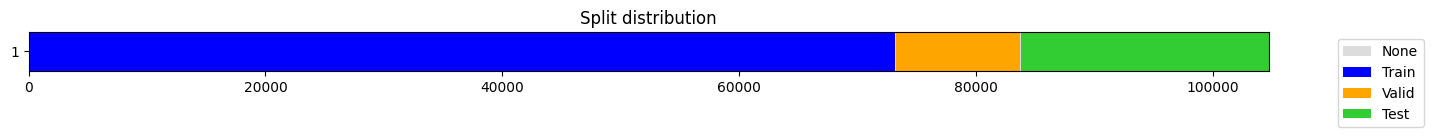

((#73182) [0,1,2,3,4,5,6,7,8,9...],
 (#10455) [73253,73254,73255,73256,73257,73258,73259,73260,73261,73262...],
 (#20909) [83779,83780,83781,83782,83783,83784,83785,83786,83787,83788...])

In [21]:
# Low SW splits
low_splits = get_forecasting_splits(low_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
low_splits

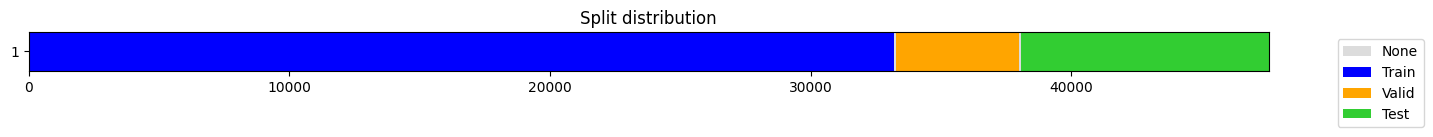

((#33196) [0,1,2,3,4,5,6,7,8,9...],
 (#4742) [33267,33268,33269,33270,33271,33272,33273,33274,33275,33276...],
 (#9485) [38080,38081,38082,38083,38084,38085,38086,38087,38088,38089...])

In [22]:
# Medium SW splits
medium_splits = get_forecasting_splits(medium_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
medium_splits

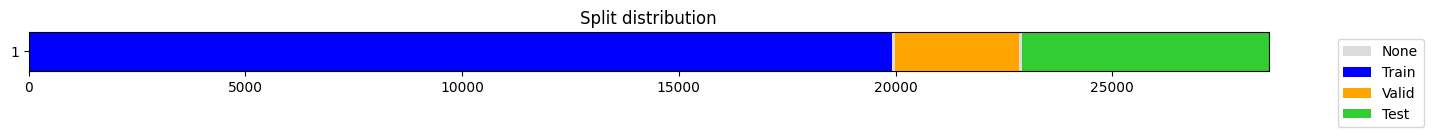

((#19926) [0,1,2,3,4,5,6,7,8,9...],
 (#2846) [19997,19998,19999,20000,20001,20002,20003,20004,20005,20006...],
 (#5693) [22914,22915,22916,22917,22918,22919,22920,22921,22922,22923...])

In [23]:
# High SW splits
high_splits = get_forecasting_splits(high_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
high_splits

In [24]:
# Set index column
low_df['index_column'] = low_df.index
# Dataset for low splits test data
low_df[low_df['index_column'].isin(low_splits[2])]

,date,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,index_column
83779,2006-07-23 19:00:00,95.238106,-15.648125,-0.997961,-0.367631,-0.690288,0.782916,2.080376,-2.016137,1.188567,...,18.777779,9.000000,9.000000,9.000000,13.444445,13.444445,5.840278,230.324997,230.699997,83779
83780,2006-07-23 20:00:00,95.272842,-15.646070,-0.995068,-0.427152,-0.811123,0.721924,2.258869,-1.564356,1.667765,...,19.140625,9.000000,9.000000,9.000000,11.111111,13.751736,6.043403,230.699997,231.074997,83780
83781,2006-07-23 21:00:00,95.290558,-15.591718,-1.073168,-0.436831,-0.897472,0.561787,2.298377,-1.080444,2.128081,...,19.506945,9.000000,9.000000,9.000000,9.000000,14.062500,6.250000,231.074997,231.449997,83781
83782,2006-07-23 22:00:00,95.288773,-15.488627,-1.226814,-0.396949,-0.944180,0.314140,2.197427,-0.597471,2.536304,...,19.876736,9.000000,9.000000,9.000000,9.000000,14.376736,6.250000,231.449997,231.824997,83782
83783,2006-07-23 23:00:00,95.191315,-15.326479,-1.429052,-0.294745,-0.920714,0.001582,1.966531,-0.146037,2.857370,...,20.250000,9.000000,9.000000,9.000000,9.000000,14.694445,6.250000,231.824997,232.199997,83783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104683,2008-12-10 19:00:00,88.893738,17.242090,1.502455,-4.689478,-0.490708,1.730058,3.132450,-2.359134,0.382757,...,13.444445,32.111111,21.777779,16.000000,7.111111,1.173611,2.777778,403.700012,381.744446,104683
104684,2008-12-10 20:00:00,88.700752,17.301682,1.617865,-4.567130,-0.760512,1.612644,3.383714,-1.795628,0.909887,...,14.062500,28.444445,28.444445,16.000000,11.111111,1.361111,2.506944,381.744446,359.733337,104684
104685,2008-12-10 21:00:00,88.395096,17.329449,1.548680,-4.475506,-0.856331,1.539595,3.367653,-1.193330,1.496726,...,14.694445,25.000000,36.000000,16.000000,16.000000,1.562500,2.250000,359.733337,337.666656,104685
104686,2008-12-10 22:00:00,87.975555,17.320751,1.296291,-4.413814,-0.766079,1.518673,3.085465,-0.594182,2.098496,...,15.340278,28.444445,32.111111,21.777779,16.000000,1.777778,2.250000,337.666656,360.622223,104686


In [25]:
# Set index column
medium_df['index_column'] = medium_df.index
# Dataset for medium splits test data
medium_df[medium_df['index_column'].isin(medium_splits[2])]

,date,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,index_column
38080,2002-11-08 22:00:00,-34.921177,0.104180,-6.298517,6.342531,-4.039907,-0.334107,0.128749,-0.148913,0.546828,...,29.793404,5.444445,28.444445,18.777779,18.777779,51.960068,356.265625,372.049988,433.970825,38080
38081,2002-11-08 23:00:00,-34.869564,0.096184,-6.390853,6.317891,-3.983293,-0.375508,-0.056793,0.005670,0.688384,...,30.250000,7.111111,13.444445,32.111111,13.444445,49.585068,342.250000,433.970825,495.866669,38081
38082,2002-11-09 00:00:00,-34.604370,-0.000243,-6.696994,6.264389,-3.898489,-0.436010,-0.292771,0.078576,0.818338,...,30.710070,9.000000,4.000000,49.000000,9.000000,47.265625,328.515625,495.866669,557.737488,38082
38083,2002-11-09 01:00:00,-34.361465,-0.052166,-6.863815,6.226776,-3.829348,-0.495863,-0.573849,0.128112,0.883331,...,31.173611,4.000000,5.444445,28.444445,18.777779,42.250000,319.515625,557.737488,371.750000,38083
38084,2002-11-09 02:00:00,-33.780506,-0.094982,-7.102399,6.197697,-3.817066,-0.642515,-0.910901,0.085929,0.903148,...,31.640625,1.000000,7.111111,13.444445,32.111111,37.515625,310.640625,371.750000,185.837494,38084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47560,2003-12-08 22:00:00,5.550200,4.084897,-2.854177,6.935560,3.445964,1.934072,4.963321,-0.064628,0.256210,...,1040.062500,1024.000000,2533.444336,1995.111084,1521.000000,594.140625,192.515625,3508.699951,2881.066650,47560
47561,2003-12-08 23:00:00,6.327982,4.238884,-3.205168,6.921571,3.344722,1.773336,4.744698,0.394143,0.708707,...,1024.000000,625.000000,1995.111084,2533.444336,1521.000000,643.890625,192.515625,2881.066650,2252.500000,47561
47562,2003-12-09 00:00:00,7.528985,4.347034,-3.807746,6.873539,3.363214,1.557506,4.342824,0.806464,1.163069,...,1008.062500,324.000000,1521.000000,3136.000000,1521.000000,695.640625,192.515625,2252.500000,1623.000000,47562
47563,2003-12-09 01:00:00,8.799214,4.497865,-4.498163,6.837649,3.349290,1.321093,3.710467,1.144167,1.558254,...,992.250000,441.000000,1024.000000,2533.444336,1995.111084,742.562500,182.250000,1623.000000,1894.900024,47563


In [26]:
# Set index column
high_df['index_column'] = high_df.index
# Dataset for high splits test data
high_df[high_df['index_column'].isin(high_splits[2])]

,date,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,index_column
22914,2002-02-02 18:00:00,-62.062328,-3.540498,-7.423769,4.313896,-2.605573,2.091529,0.163680,-2.171849,1.881912,...,213.890625,25.000000,225.000000,484.000000,324.000000,301.890625,129.390625,1977.500000,1185.500000,22914
22915,2002-02-02 19:00:00,-60.434952,-3.521198,-7.741947,4.473854,-2.953182,1.509226,0.166331,-2.058926,1.883130,...,196.000000,40.111111,136.111115,386.777771,373.777771,315.062500,136.111115,1185.500000,1500.366699,22915
22916,2002-02-02 20:00:00,-60.380527,-3.434205,-7.717774,4.464355,-2.952757,1.480138,0.225611,-1.942992,1.977104,...,178.890625,58.777779,69.444443,300.444458,427.111115,328.515625,143.001740,1500.366699,1814.699951,22916
22917,2002-02-02 21:00:00,-60.129848,-3.380153,-7.753454,4.470144,-2.981314,1.393132,0.230729,-1.807137,2.064848,...,162.562500,81.000000,25.000000,225.000000,484.000000,342.250000,150.062500,1814.699951,2128.500000,22917
22918,2002-02-02 22:00:00,-59.633953,-3.367383,-7.867568,4.495108,-3.052473,1.229454,0.168105,-1.663283,2.134303,...,147.015625,69.444443,40.111111,136.111115,386.777771,342.250000,171.173615,2128.500000,1969.166626,22918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28602,2002-09-27 18:00:00,-25.446453,2.579900,2.402007,7.592635,-3.037750,-1.798271,0.601644,-0.658951,-0.818843,...,32.585068,9.000000,36.000000,36.000000,25.000000,42.250000,14.062500,604.000000,453.200012,28602
28603,2002-09-27 19:00:00,-24.913216,2.755273,2.561424,7.613800,-3.395328,-2.007504,0.845213,-0.401492,-0.552375,...,32.111111,16.000000,25.000000,36.000000,28.444445,42.793404,14.694445,453.200012,604.533325,28603
28604,2002-09-27 20:00:00,-25.200861,2.859648,2.636891,7.586258,-3.429877,-1.976317,0.991399,-0.127104,-0.266095,...,31.640625,25.000000,16.000000,36.000000,32.111111,43.340279,15.340278,604.533325,756.000000,28604
28605,2002-09-27 21:00:00,-25.462126,2.926976,2.632843,7.549744,-3.412131,-1.966317,1.012671,0.175025,0.037569,...,31.173611,36.000000,9.000000,36.000000,36.000000,43.890625,16.000000,756.000000,907.599976,28605


In [27]:
# Save splits
mkdir('training/splits/', exist_ok=True, parents=True)

save_object(low_splits, 'training/splits/splits_lowSW_'+path+'.pkl')
save_object(medium_splits, 'training/splits/splits_mediumSW_'+path+'.pkl')
save_object(high_splits, 'training/splits/splits_highSW_'+path+'.pkl')

training/splits/splits_lowSW_data directory created.
tuple saved as training/splits/splits_lowSW_data/NRLMSISE.pkl
training/splits/splits_mediumSW_data directory created.
tuple saved as training/splits/splits_mediumSW_data/NRLMSISE.pkl
training/splits/splits_highSW_data directory created.
tuple saved as training/splits/splits_highSW_data/NRLMSISE.pkl


### Scale dataframe

Now that we have defined the splits for this particular experiment, we'll scale the data: 

#### Create new scaled data

In [28]:
# Parameters
columns = low_df.columns[1:]
train_split = low_splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
mkdir('training/exp_pipe/', exist_ok=True, parents=True)
save_object(exp_pipe, 'training/exp_pipe/exp_pipe_lowSW_'+path+'.pkl')
exp_pipe = load_object('training/exp_pipe/exp_pipe_lowSW_'+path+'.pkl')

# scale low SW data
low_df_scaled = exp_pipe.fit_transform(low_df, scaler__idxs=train_split)
low_df_scaled

training/exp_pipe/exp_pipe_lowSW_data directory created.
Pipeline saved as training/exp_pipe/exp_pipe_lowSW_data/NRLMSISE.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.3s


,date,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,index_column
0,1997-01-01 00:00:00,2.745686,3.026989,-1.202083,-3.861976,0.012597,1.292468,1.548578,-0.812086,2.101198,...,-0.220161,-0.089708,-0.138700,-0.131463,-0.237406,-0.138560,-0.041345,-0.683487,-0.478688,-1.732015
1,1997-01-01 01:00:00,2.722665,3.012281,-1.349944,-3.910456,0.253655,1.384347,0.884480,-0.574106,2.484624,...,-0.220161,-0.092174,-0.136470,-0.133936,-0.232516,-0.139437,-0.038897,-0.683487,-0.496990,-1.731968
2,1997-01-01 02:00:00,2.696917,2.990748,-1.506326,-3.961501,0.542375,1.508343,0.161003,-0.429309,2.749313,...,-0.220161,-0.094521,-0.134118,-0.136287,-0.226540,-0.140301,-0.036418,-0.701501,-0.515292,-1.731921
3,1997-01-01 03:00:00,2.672634,2.965264,-1.659892,-4.019433,0.849534,1.650332,-0.570046,-0.388954,2.880188,...,-0.220161,-0.096747,-0.131646,-0.138518,-0.219478,-0.141151,-0.033909,-0.719515,-0.533594,-1.731873
4,1997-01-01 04:00:00,2.651421,2.937543,-1.799965,-4.079888,1.154380,1.799336,-1.258688,-0.453854,2.872232,...,-0.220161,-0.102704,-0.134118,-0.136287,-0.221953,-0.139437,-0.035585,-0.737530,-0.588500,-1.731826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105186,2008-12-31 18:00:00,2.985404,2.884660,-0.660527,-3.753944,0.991445,2.766645,2.406109,-2.655788,-1.800583,...,-0.035017,-0.038265,-0.114283,-0.114097,-0.070078,-0.123796,-0.139368,-0.497123,-0.237195,3.246975
105187,2008-12-31 19:00:00,2.994585,2.917001,-0.530416,-3.705268,0.737316,2.656607,2.972199,-2.334396,-1.457822,...,-0.035017,-0.050720,-0.103973,-0.114097,-0.123862,-0.113491,-0.139481,-0.445789,-0.289348,3.247023
105188,2008-12-31 20:00:00,3.012799,2.963799,-0.451017,-3.714313,0.522304,2.553634,3.309834,-1.949947,-0.935912,...,-0.035017,-0.062091,-0.092578,-0.114097,-0.167867,-0.102101,-0.139581,-0.497123,-0.341501,3.247070
105189,2008-12-31 21:00:00,3.029283,3.010176,-0.431708,-3.757917,0.381587,2.473478,3.397147,-1.525033,-0.306749,...,-0.035017,-0.072380,-0.080097,-0.114097,-0.202093,-0.089627,-0.139668,-0.548456,-0.393654,3.247117


In [29]:
# Parameters
columns = medium_df.columns[1:]
train_split = medium_splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'training/exp_pipe/exp_pipe_mediumSW_'+path+'.pkl')
exp_pipe = load_object('training/exp_pipe/exp_pipe_mediumSW_'+path+'.pkl')

#scale medium SW data
medium_df_scaled = exp_pipe.fit_transform(medium_df, scaler__idxs=train_split)
medium_df_scaled

training/exp_pipe/exp_pipe_mediumSW_data directory created.
Pipeline saved as training/exp_pipe/exp_pipe_mediumSW_data/NRLMSISE.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s


,date,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,index_column
0,1998-07-06 06:00:00,1.911206,-1.944067,0.452175,-0.974457,4.033596,-0.719438,-0.831839,1.105306,1.086405,...,0.088374,0.095527,0.239249,-0.120018,-0.216235,-0.456088,-0.113433,0.498903,0.375375,-1.731973
1,1998-07-06 07:00:00,1.918258,-2.017006,0.418196,-0.962573,4.085484,-0.742830,-1.151042,0.887145,0.710424,...,0.095601,0.027105,0.178324,-0.027707,-0.188416,-0.457816,-0.113433,0.394745,0.234276,-1.731868
2,1998-07-06 08:00:00,1.923046,-2.093775,0.396536,-0.935869,4.119590,-0.743773,-1.390594,0.581443,0.307239,...,0.102876,-0.033653,0.121279,0.086325,-0.155034,-0.459530,-0.113433,0.250488,0.093708,-1.731764
3,1998-07-06 09:00:00,1.936695,-2.177096,0.390597,-0.910844,4.110761,-0.738259,-1.523802,0.220410,-0.106405,...,0.110201,-0.086748,0.068116,0.222077,-0.116089,-0.461231,-0.113433,0.106772,-0.046331,-1.731659
4,1998-07-06 10:00:00,1.958600,-2.261801,0.400720,-0.888646,4.060207,-0.726962,-1.540929,-0.169918,-0.498153,...,0.117575,0.230650,0.000206,0.162874,-0.021507,-0.467901,-0.092658,-0.036401,0.601619,-1.731555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48063,2003-12-29 21:00:00,2.237673,2.828229,-1.191396,-0.146369,0.482302,-1.161397,2.231271,-0.426765,0.381587,...,-0.394982,-0.242280,-0.258784,-0.120018,-0.247530,-0.543993,0.034299,-0.800979,-0.829276,3.283469
48064,2003-12-29 22:00:00,2.304815,3.107415,-1.240130,-0.289241,0.293054,-1.282530,1.933790,-0.276606,0.984528,...,-0.394272,-0.240091,-0.262199,-0.185557,-0.216235,-0.545593,0.044131,-0.836873,-0.794619,3.283574
48065,2003-12-29 23:00:00,2.301706,3.122957,-1.262343,-0.306277,0.374939,-1.277990,1.702317,0.009505,1.326885,...,-0.393556,-0.237276,-0.264993,-0.232844,-0.172421,-0.547141,0.054134,-0.801441,-0.760075,3.283678
48066,2003-12-30 00:00:00,2.318731,3.151178,-1.299632,-0.360543,0.477993,-1.291273,1.372973,0.204644,1.653020,...,-0.392835,-0.233835,-0.267166,-0.261879,-0.116089,-0.548635,0.064307,-0.766123,-0.725644,3.283782


In [30]:
# Parameters
columns = high_df.columns[1:]
train_split = high_splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'training/exp_pipe/exp_pipe_highSW_'+path+'.pkl')
exp_pipe = load_object('training/exp_pipe/exp_pipe_highSW_'+path+'.pkl')

# Scale high SW data
high_df_scaled = exp_pipe.fit_transform(high_df, scaler__idxs=train_split)
high_df_scaled

training/exp_pipe/exp_pipe_highSW_data directory created.
Pipeline saved as training/exp_pipe/exp_pipe_highSW_data/NRLMSISE.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,ap1_future^2,ap2_future^2,ap3_future^2,ap4_future^2,ap5_future^2,ap6_future^2,ap7_future^2,Mixed,Mixed_future,index_column
0,1999-06-24 00:00:00,1.573783,-0.254103,1.445838,-1.768345,0.827465,-1.028907,1.034955,-0.187332,2.339580,...,-0.306601,-0.173261,-0.156182,-0.142623,-0.128039,-0.207410,-0.229251,-0.538995,-0.609944,-1.731920
1,1999-06-24 01:00:00,1.560949,-0.182334,1.420388,-1.777667,0.926661,-1.088247,0.724354,0.003408,2.421788,...,-0.306601,-0.174112,-0.158521,-0.140748,-0.126868,-0.207410,-0.229251,-0.567562,-0.624030,-1.731747
2,1999-06-24 02:00:00,1.554848,-0.136388,1.395114,-1.789059,1.027019,-1.153767,0.373091,0.125888,2.406501,...,-0.306601,-0.174903,-0.160626,-0.138638,-0.125462,-0.207410,-0.229251,-0.581727,-0.638159,-1.731573
3,1999-06-24 03:00:00,1.549678,-0.112777,1.370149,-1.801450,1.133869,-1.212627,0.007480,0.167119,2.290001,...,-0.306601,-0.175636,-0.162497,-0.136295,-0.123822,-0.207410,-0.229251,-0.595935,-0.652331,-1.731399
4,1999-06-24 04:00:00,1.546069,-0.112972,1.348164,-1.814171,1.237006,-1.261787,-0.344589,0.124336,2.083022,...,-0.306601,-0.176310,-0.163345,-0.138638,-0.121948,-0.206865,-0.229251,-0.610186,-0.666546,-1.731225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29105,2002-10-18 17:00:00,-0.446234,-0.316370,-0.658635,1.110989,-0.532369,0.591991,0.245150,-0.079217,-1.820513,...,-0.172066,-0.135270,-0.109867,-0.109107,-0.114920,-0.134839,0.020115,-0.154948,-0.245227,3.327808
29106,2002-10-18 18:00:00,-0.434726,-0.196970,-0.631095,1.117409,-0.623958,0.564149,0.482423,0.000531,-1.690101,...,-0.172066,-0.141866,-0.109867,-0.089889,-0.117497,-0.136527,0.026130,-0.200805,-0.290694,3.327982
29107,2002-10-18 19:00:00,-0.419309,-0.084663,-0.609385,1.122317,-0.712980,0.526638,0.674647,0.131072,-1.506655,...,-0.172066,-0.135270,-0.117498,-0.089889,-0.105783,-0.135967,0.023113,-0.246526,-0.246986,3.328156
29108,2002-10-18 20:00:00,-0.435063,0.002423,-0.589127,1.110611,-0.729550,0.547642,0.818622,0.281368,-1.253595,...,-0.172066,-0.128146,-0.124603,-0.089889,-0.090321,-0.135404,0.020115,-0.202573,-0.203412,3.328329


In [31]:
# Save data
mkdir('training/training_data/', exist_ok=True, parents=True)
save_object(low_df, 'training/training_data/low_df_'+path+'.pkl')
save_object(medium_df, 'training/training_data/medium_df_'+path+'.pkl')
save_object(high_df, 'training/training_data/high_df_'+path+'.pkl')

training/training_data/low_df_data directory created.
DataFrame saved as training/training_data/low_df_data/NRLMSISE.pkl
training/training_data/medium_df_data directory created.
DataFrame saved as training/training_data/medium_df_data/NRLMSISE.pkl
training/training_data/high_df_data directory created.
DataFrame saved as training/training_data/high_df_data/NRLMSISE.pkl


## Load Scaled Data

In [32]:
# Low SW
columns = low_df.columns[1:]
train_split = low_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_lowSW_'+path+'.pkl')
low_df_scaled = exp_pipe.fit_transform(low_df, scaler__idxs=train_split)

# Medium SW
columns = medium_df.columns[1:]
train_split = medium_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_mediumSW_'+path+'.pkl')
medium_df_scaled = exp_pipe.fit_transform(medium_df, scaler__idxs=train_split)

# High SW
columns = high_df.columns[1:]
train_split = high_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_highSW_'+path+'.pkl')
high_df_scaled = exp_pipe.fit_transform(high_df, scaler__idxs=train_split)

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.2s
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


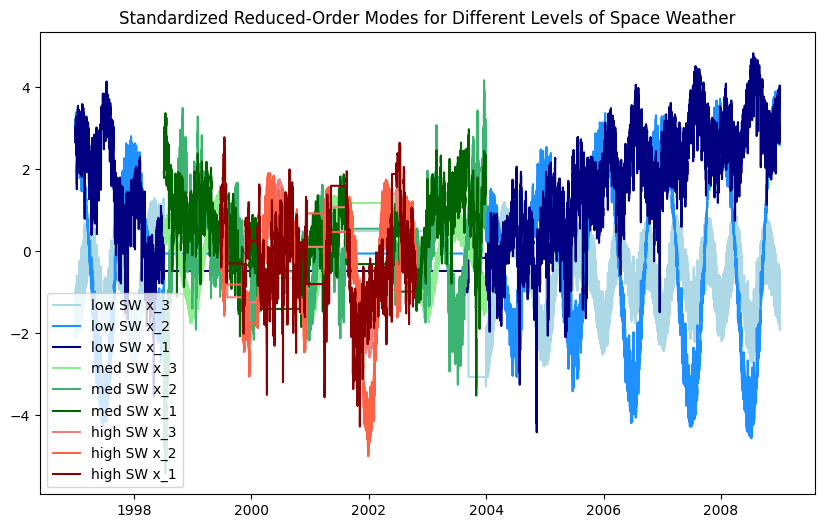

In [43]:
plt.figure(figsize=(10,6))  # Pplot of first three reduced order modes
low_colors = ['lightblue', 'dodgerblue', 'navy']      # Shades of blue for 'low' group
medium_colors = ['lightgreen', 'mediumseagreen', 'darkgreen']  # Shades of green for 'medium' group
high_colors = ['lightcoral', 'tomato', 'darkred']         # Shades of red for 'high' group

plt.plot(low_df["date"],low_df["x_3"], label='low SW x_3', color=low_colors[0])
plt.plot(low_df["date"],low_df["x_2"], label='low SW x_2', color=low_colors[1])
plt.plot(low_df["date"],low_df["x_1"], label='low SW x_1', color=low_colors[2])

plt.plot(medium_df["date"],medium_df["x_3"], label='med SW x_3', color=medium_colors[0])
plt.plot(medium_df["date"],medium_df["x_2"], label='med SW x_2', color=medium_colors[1])
plt.plot(medium_df["date"],medium_df["x_1"], label='med SW x_1', color=medium_colors[2])

plt.plot(high_df["date"],high_df["x_3"], label='high SW x_3', color=high_colors[0])
plt.plot(high_df["date"],high_df["x_2"], label='high SW x_2', color=high_colors[1])
plt.plot(high_df["date"],high_df["x_1"], label='high SW x_1', color=high_colors[2])

plt.title("Standardized Reduced-Order Modes for Different Levels of Space Weather")

plt.legend()
plt.show()